### Imports

In [55]:
import numpy as np
import re
from matplotlib import pyplot as plt
from pymongo import MongoClient
from tqdm.notebook import tqdm
from pprint import PrettyPrinter
from typing import Union, Iterable

pprint = PrettyPrinter().pprint

### Load DB

In [33]:
db = MongoClient("mongodb://localhost:27017")["cuda_snippets"]
train_db = db["train"]
validation_db = db["validation"]

Analyze compile error ratio

In [34]:
not_validated = train_db.count_documents({"validation" : {"$exists" : False}}) + \
    validation_db.count_documents({"validation" : {"$exists" : False}})
compiled_successfully = train_db.count_documents({"validation.compiled" : True}) + \
    validation_db.count_documents({"validation.compiled" : True})
compiled_failed = train_db.count_documents({"validation.compiled" : False}) + \
    validation_db.count_documents({"validation.compiled" : False})

s = sum([not_validated, compiled_successfully, compiled_failed])
           
print(f"not validated : {not_validated} ({not_validated/s:.2%})")
print(f"compiled      : {compiled_successfully} ({compiled_successfully/s:.2%})")
print(f"failed        : {compiled_failed} ({compiled_failed/s:.2%})")



not validated : 0 (0.00%)
compiled      : 76635 (40.37%)
failed        : 113184 (59.63%)


Plot functions

In [35]:
SUBPLOT_TYPES = {
    "line" : "line",
    "bar" : "bar",
    "scatter" : "scatter"
}

PLOT_TYPES = {
    "line" : plt.plot,
    "bar" : plt.bar,
    "scatter" : plt.scatter
}

def sub_plot(data : Union[list, np.ndarray], labels : Iterable, title = "", xlab = "", ylab = "", plot_type = "line"):
    for label_data, label in zip(data, labels):
        if type(label) in [list, tuple]:
            assert len(label_data) == len(label)
        else:
            assert len(label_data) == len(labels)
    
    # All label data have same number class data
    for label_data in data:
        assert all(class_data == label_data[0] for class_data in label_data)

    x_dim = len(data)    
    y_dim = len(data[0])
    
    fig, ax = plt.subplots(y_dim, x_dim)
    plt.title(title)
    
    for i, (label_data, label) in enumerate(zip(data, labels)):
        x_idx = i % x_dim
        y_idx = i // y_dim
        axs = ax[x_idx][y_idx]
        
        plot_types = {
            "line" : axs.plot,
            "bar" : axs.bar,
            "scatter" : axs.scatter
        }
        
        axs.set_xlabel(xlab)
        axs.set_ylabel(ylab)
        
        if type(label) in [list, tuple]:
            plot_types.get(plot_type)(label_data, label)
        else:
            plot_types.get(plot_type)(label_data, labels)
        
        axs.legend()
    
    fig.show()

    
def plot(data : Union[list, np.ndarray], labels : Iterable, title = "", xlab = "", ylab = "", plot_type=plt.plot):
    assert len(data) == len(labels)
    
    plt.tight_layout()
    plt.figure()
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    for label_data, label in zip(data, labels):
        plt.bar()
        plot_type(label_data, label=label)
        
    plt.legend()
    plt.show()
    
def plot_bar(x, height, labels, title = "", xlab = "", ylab = "", plot_type=plt.plot):
    assert len(x) == len(labels) and len(height) == len(labels)
    
    plt.tight_layout()
    plt.figure()
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    for label_x, label_height, label in zip(x, height, labels):
        plt.bar(label_x, label_height, label=label)
        
    plt.legend()
    plt.show()
    

Get histogram of errors (Counts only one type of error per kernel)

In [36]:
def count_errors(collection) -> dict:

    kernel_validation_list = []
    missing_tokens_error_counter = 0
    wrong_vals_error_counter = 0
    syntax_error_counter = 0
    missing_types_error_counter = 0
    include_error_counter = 0

    train_not_compiled_kernels = collection.find({"validation.compiled" : False})
    for kernel in tqdm(train_not_compiled_kernels, leave=False):
        last_error_analysis = kernel.get("validation").get("iterations")[-1].get("error_analyses")
        kernel_validation_list.append({**last_error_analysis, "id" : kernel["_id"]})
        if len(last_error_analysis.get("missing_tokens")) > 0:
            missing_tokens_error_counter += 1
        if len(last_error_analysis.get("wrong_vals")) > 0:
            wrong_vals_error_counter += 1
        if len(last_error_analysis.get("syntax_errors")) > 0:
            syntax_error_counter += 1
        if len(last_error_analysis.get("missing_types")) > 0:
            missing_types_error_counter += 1
        if len(last_error_analysis.get("include_errors")) > 0:
            include_error_counter += 1
            
    return {
        "kernel_validations" :  kernel_validation_list,
        "missing_tokens" : missing_tokens_error_counter,
        "wrong_vals" : wrong_vals_error_counter,
        "syntax_errors" : syntax_error_counter,
        "missing_types" : missing_types_error_counter,
        "include_errors" : include_error_counter
    }


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train. errors:
{'include_errors': 0,
 'missing_tokens': 74018,
 'missing_types': 17131,
 'syntax_errors': 38380,
 'wrong_vals': 240}
val. errors:
{'include_errors': 0,
 'missing_tokens': 12579,
 'missing_types': 3054,
 'syntax_errors': 5554,
 'wrong_vals': 131}
total errors:
{'include_errors': 0,
 'missing_tokens': 86597,
 'missing_types': 20185,
 'syntax_errors': 43934,
 'wrong_vals': 371}


<Figure size 640x480 with 0 Axes>

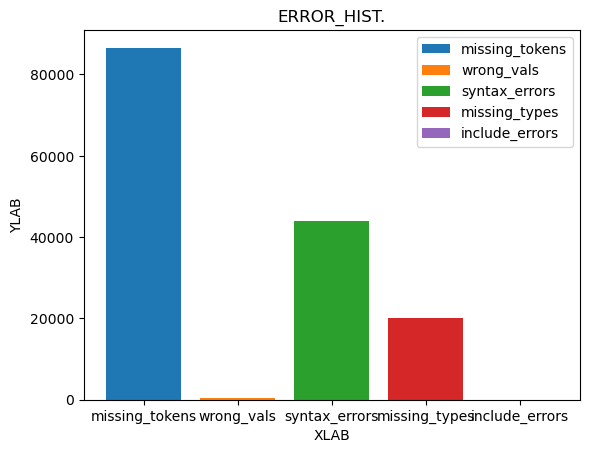

In [37]:
def sum_dicts(*ds) -> dict:
    result = {}
    for d in ds:        
        for k, v in d.items():
            if k not in result:
                result[k] = 0
            result[k] += v
    
    return result

train_errors = count_errors(train_db)
val_errors = count_errors(validation_db)

kernel_validation_list = [*train_errors.get("kernel_validations"), *val_errors.get("kernel_validations")]
del train_errors["kernel_validations"]
del val_errors["kernel_validations"]

print("train. errors:")
pprint(train_errors)

print("val. errors:")
pprint(val_errors)

total_errors = sum_dicts(train_errors, val_errors)
print("total errors:")
pprint(total_errors)
plot_bar(total_errors.keys(), total_errors.values(), total_errors.keys(), "ERROR_HIST.", "XLAB", "YLAB")



Most common missing tokens

In [40]:
missing_tokens_dict = {}
for kernel_validation in tqdm(kernel_validation_list):
    missing_tokens_set = set()
    for missing_token in kernel_validation.get("missing_tokens"):
        if missing_token.get("identifier") in missing_tokens_set:
            continue
        
        missing_tokens_set.add(missing_token.get("identifier"))
        if missing_token.get("identifier") not in missing_tokens_dict:
            missing_tokens_dict[missing_token.get("identifier")] = 0
        missing_tokens_dict[missing_token.get("identifier")] += 1

show_first_n = 20
print(f"total missing tokens = {len(missing_tokens_dict)}\nShowing first {show_first_n}:")
first_n_keys = sorted(missing_tokens_dict.items(), key=lambda x : x[1], reverse=True)[:show_first_n]
for i, (val) in enumerate(first_n_keys, 1):
    print(f"{i}.\t{val}")


  0%|          | 0/113184 [00:00<?, ?it/s]

total missing tokens = 30765
Showing first 20:
1.	('cta', 3261)
2.	('uint32_t', 2949)
3.	('vec3', 2596)
4.	('z', 2416)
5.	('T', 2323)
6.	('get_high_word', 2247)
7.	('set_high_word', 2247)
8.	('trim', 2247)
9.	('curandState', 2085)
10.	('i', 1920)
11.	('CUDA_1D_KERNEL_LOOP', 1774)
12.	('composite', 1767)
13.	('set_float_word', 1734)
14.	('insert_words', 1734)
15.	('uint64_t', 1350)
16.	('uint8_t', 1187)
17.	('Ray', 1027)
18.	('x', 973)
19.	('binary_operator', 962)
20.	('magmaDoubleComplex', 920)


Show kernels with specified error

In [52]:
wanted_token = "get_high_word"
wanted_kernels_ids = []
for kernel_validation in tqdm(kernel_validation_list):
    missing_tokens = set([missing_token_obj.get("identifier") for missing_token_obj in kernel_validation.get("missing_tokens")])
    if wanted_token in missing_tokens:
        wanted_kernels_ids.append(kernel_validation.get("id"))

wanted_kernels_ids = list(set(wanted_kernels_ids))
print("Wanted kernels total:", len(wanted_kernels_ids))

  0%|          | 0/113184 [00:00<?, ?it/s]

Wanted kernels total: 2247


In [57]:
def get_kernels_by_id_list(id_list : list) -> list:
    return [*list(train_db.find({"_id" : {"$in" : id_list}})), *list(validation_db.find({"_id" : {"$in" : id_list}}))]

In [58]:
wanted_kernels = get_kernels_by_id_list(wanted_kernels_ids)
print(f"Found {len(wanted_kernels)} wanted kernels out of total {len(wanted_kernels_ids)}")

print(wanted_kernels[0].get("_id"))
print(wanted_kernels[0].get("header"))


Found 2247 wanted kernels out of total 2247
640f721f5dafbcc19b03cc1a
__host__ __device__ inline
float frexp_expf(float x, int *expt)


## Syntax error analysis

In [68]:
syntax_error_tokens = {}
wanted_kernel_ids = set()
expected_token_re = re.compile(".*expected a \"(\S+)\"")
for kernel_validation in tqdm(kernel_validation_list):
    for syntax_error_obj in kernel_validation.get("syntax_errors"):
        if res := expected_token_re.match(syntax_error_obj["line"]):
            if res[1] not in syntax_error_tokens:
                syntax_error_tokens[res[1]] = 0
            syntax_error_tokens[res[1]] += 1
            wanted_kernel_ids.add(kernel_validation.get("id"))

show_first_n = min(20, len(syntax_error_tokens))
print(f"total expected tokens = {len(syntax_error_tokens)}\nShowing first {show_first_n}:")
first_n_keys = sorted(syntax_error_tokens.items(), key=lambda x : x[1], reverse=True)[:show_first_n]
for i, (val) in enumerate(first_n_keys, 1):
    print(f"{i}.\t{val}")

  0%|          | 0/113184 [00:00<?, ?it/s]

total expected tokens = 9
Showing first 9:
1.	(';', 65775)
2.	(']', 31584)
3.	(')', 17986)
4.	('>', 911)
5.	(',', 266)
6.	('}', 160)
7.	('{', 119)
8.	('(', 30)
9.	(':', 8)


In [70]:
wanted_kernels = get_kernels_by_id_list(list(wanted_kernel_ids))
print(f"Found {len(wanted_kernels)} wanted kernels out of total {len(wanted_kernel_ids)}")


print(wanted_kernels[0].get("_id"))
print(wanted_kernels[0].get("header"))

Found 43910 wanted kernels out of total 43910
640f71cb5dafbcc19b0351c0
__device__ bool xy_rect::hit(const ray& r, float t_min, float t_max, hit_record& rec) const 
